## CWRU Data Analytics
**Unit 10 | Assignment - Surf's Up!**

Robert Wood  
4/20/2019

In [251]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [252]:
import numpy as np
import pandas as pd

In [253]:
import datetime as dt
from datetime import datetime,timedelta,date

# Reflect Tables into SQLAlchemy ORM

In [254]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [255]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [256]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [257]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [258]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [259]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [260]:
# Preview table structure for 'measurement'

# Get a list of column names and types
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [261]:
# View formatting of data for 'measurement'
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [262]:
# Preview table structure for 'station'

# Get a list of column names and types
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [263]:
# View formatting of data for 'station'
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [264]:
# View date range of available data
earliest = session.query(Measurement.date).order_by(Measurement.date).first()
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Date range available is {earliest[0]} to {latest[0]}.")

Date range available is 2010-01-01 to 2017-08-23.


In [265]:
# Query and store last date in database
result = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
query_date = datetime.strptime(result,'%Y-%m-%d')
query_date

datetime.datetime(2017, 8, 23, 0, 0)

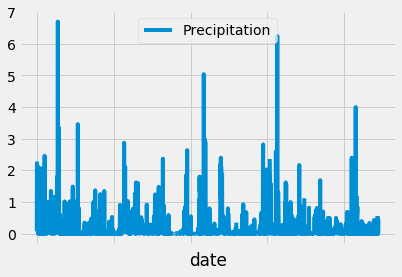

In [266]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
year_ago = query_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.date <= query_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp, columns=['date', 'Precipitation'])
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x_compat=True)
plt.savefig("output/precipitation_bar.png")

In [267]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [268]:
# Design a query to show how many stations are available in this dataset?

stations = session.query(Station).distinct(Station.id).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.date <= query_date).count()

print(f"There are {stations} stations in this dataset.")

There are 9 stations in this dataset.


In [269]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Print header
print("Station      Count\n"
     "-----------  -----")

# Print results
for station,count in active_stations:
    print(f"{station}  {count}")

Station      Count
-----------  -----
USC00519281  2772
USC00519397  2724
USC00513117  2709
USC00519523  2669
USC00516128  2612
USC00514830  2202
USC00511918  1979
USC00517948  1372
USC00518838  511


In [270]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# Store the most active station
most_active = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()[0]

# Query and store remperature results for this station
results = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()

# Print header
print(f"Results for most active station ({most_active})\n"
     "----------------------------------------------")

# Print results
for result in results:
    print(f"Lowest Temp.: {'{:.2f}'.format(result[0])} F\n"
         f"Highest Temp.: {'{:.2f}'.format(result[1])} F\n"
         f"Average Temp.: {'{:.2f}'.format(result[2])} F")

Results for most active station (USC00519281)
----------------------------------------------
Lowest Temp.: 54.00 F
Highest Temp.: 85.00 F
Average Temp.: 71.66 F


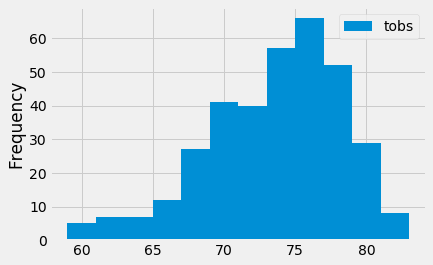

In [271]:
# Choose the station with the highest number of temperature observations.

# Query to find and store the station with the highest number of tobs
highest_tobs = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()[0][0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query to find and store tobs data for this station
tobs = session.query(Measurement.tobs).\
    filter(Measurement.station == highest_tobs).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.date <= query_date).all()

# Create a DataFrame
tobs_df = pd.DataFrame(tobs, columns=['tobs'])

# Plot the histogram
tobs_df.plot.hist(bins=12)
plt.savefig("output/temperature_histogram.png")

In [272]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [273]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Store result of calc_temps for the start and end date
results = calc_temps('2011-02-28', '2011-03-05')

# Print header
print("Previous Year Data")
print("------------------")

# Print results
for result in results:
    print(f"Min. Temp.: {'{:.2f}'.format(result[0])} F\n"
         f"Avg. Temp.: {'{:.2f}'.format(result[1])} F\n"
         f"Max. Temp.: {'{:.2f}'.format(result[2])} F")

Previous Year Data
------------------
Min. Temp.: 61.00 F
Avg. Temp.: 69.76 F
Max. Temp.: 75.00 F


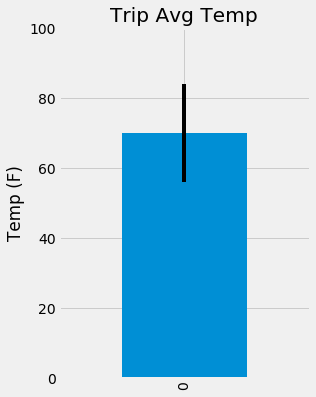

In [274]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Store results of calc_temps
temp_list = calc_temps('2011-02-28', '2011-03-05')

# Assign the results to a DataFrame
temp_df = pd.DataFrame(temp_list, columns=['min','avg','max'])

# Create the bar plot
temp_df.plot.bar(y='avg',title="Trip Avg Temp",yerr=temp_df['max']-temp_df['min'],legend=False,figsize=(4,6))
plt.ylabel("Temp (F)")
plt.yticks([0,20,40,60,80,100])
plt.savefig("output/temperature.png")

In [275]:
# Set start and end dates
start_date = '2012-02-28'
end_date = '2012-03-05'

# Query database
results = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

# Format and print results
for result in results:
    print(f"Station: {result[0]}\n"
          f"Name: {result[1]}\n"
          f"Lat/Lng: {'{:.2f}'.format(result[2])}, {'{:.2f}'.format(result[3])}\n"
          f"Elevation: {result[4]} m\n"
          f"Precipitation: {'{:.2f}'.format(result[5])} cm\n")

Station: USC00519281
Name: WAIHEE 837.5, HI US
Lat/Lng: 21.45, -157.85
Elevation: 32.9 m
Precipitation: 11.08 cm

Station: USC00516128
Name: MANOA LYON ARBO 785.2, HI US
Lat/Lng: 21.33, -157.80
Elevation: 152.4 m
Precipitation: 10.32 cm

Station: USC00513117
Name: KANEOHE 838.1, HI US
Lat/Lng: 21.42, -157.80
Elevation: 14.6 m
Precipitation: 5.79 cm

Station: USC00518838
Name: UPPER WAHIAWA 874.3, HI US
Lat/Lng: 21.50, -158.01
Elevation: 306.6 m
Precipitation: 3.84 cm

Station: USC00519523
Name: WAIMANALO EXPERIMENTAL FARM, HI US
Lat/Lng: 21.34, -157.71
Elevation: 19.5 m
Precipitation: 2.92 cm

Station: USC00519397
Name: WAIKIKI 717.2, HI US
Lat/Lng: 21.27, -157.82
Elevation: 3.0 m
Precipitation: 1.18 cm

Station: USC00511918
Name: HONOLULU OBSERVATORY 702.2, HI US
Lat/Lng: 21.32, -158.00
Elevation: 0.9 m
Precipitation: 0.76 cm

Station: USC00514830
Name: KUALOA RANCH HEADQUARTERS 886.9, HI US
Lat/Lng: 21.52, -157.84
Elevation: 7.0 m
Precipitation: 0.03 cm

Station: USC00517948
Name: PE

## Optional Challenge Assignment

In [276]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [277]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = datetime.strptime(start_date,'%Y-%m-%d')
end = datetime.strptime(end_date,'%Y-%m-%d')

# Use the start and end date to create a range of dates
date_list = [start + timedelta(days=x) for x in range((end-start).days + 1)]

# Stip off the year and save a list of %m-%d strings
month_day = []
for date in date_list:
    month_day.append(str(date.strftime('%m')) + '-' + str(date.strftime('%d')))

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for m_d in month_day:
    normals.append(daily_normals(m_d)[0])

normals

[(65.0, 70.65517241379311, 80.0),
 (67.0, 71.73333333333333, 79.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [278]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

# Create list of stringified dates
date_index = []
for date in date_list:
    date_index.append(datetime.strftime(date,'%Y-%m-%d'))

# Create DataFrame
normals_df = pd.DataFrame(normals,columns=('tmin','tavg','tmax'))
normals_df['date'] = date_index
normals_df.set_index(['date'],inplace=True)

# View resulting DataFrame
normals_df

,tmin,tavg,tmax
date,,,
2012-02-28,65.0,70.655172,80.0
2012-02-29,67.0,71.733333,79.0
2012-03-01,64.0,70.032787,76.0
2012-03-02,61.0,70.366667,78.0
2012-03-03,60.0,70.068966,78.0
2012-03-04,57.0,69.272727,77.0
2012-03-05,60.0,67.890909,76.0


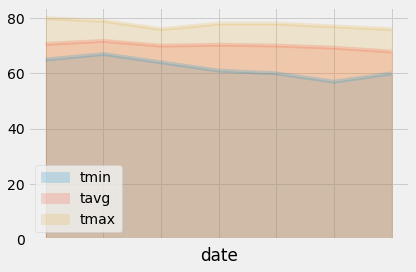

In [279]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.savefig("output/daily_normals.png")
plt.tight_layout()